# **Data Science in Marketing: Customer Churn Prediction**

## Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
import pickle

## Data Preparation

Load the dataset

In [2]:
url = 'https://storage.googleapis.com/dqlab-dataset/dqlab_telco_final.csv'
df = pd.read_csv(url)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6950 entries, 0 to 6949
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   UpdatedAt         6950 non-null   int64  
 1   customerID        6950 non-null   int64  
 2   gender            6950 non-null   object 
 3   SeniorCitizen     6950 non-null   object 
 4   Partner           6950 non-null   object 
 5   tenure            6950 non-null   int64  
 6   PhoneService      6950 non-null   object 
 7   StreamingTV       6950 non-null   object 
 8   InternetService   6950 non-null   object 
 9   PaperlessBilling  6950 non-null   object 
 10  MonthlyCharges    6950 non-null   float64
 11  TotalCharges      6950 non-null   float64
 12  Churn             6950 non-null   object 
dtypes: float64(2), int64(3), object(8)
memory usage: 706.0+ KB


In [4]:
df.shape

(6950, 13)

In [5]:
df.head()

,UpdatedAt,customerID,gender,SeniorCitizen,Partner,tenure,PhoneService,StreamingTV,InternetService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn
0,202006,45759018157,Female,No,Yes,1,No,No,Yes,Yes,29.85,29.85,No
1,202006,45315483266,Male,No,Yes,60,Yes,No,No,Yes,20.50,1198.80,No
2,202006,45236961615,Male,No,No,5,Yes,Yes,Yes,No,104.10,541.90,Yes
3,202006,45929827382,Female,No,Yes,72,Yes,Yes,Yes,Yes,115.50,8312.75,No
4,202006,45305082233,Female,No,Yes,56,Yes,Yes,Yes,No,81.25,4620.40,No


In [6]:
df.customerID.nunique()

6950

## Exploratory Data Analysis

Visualize the churn percentage

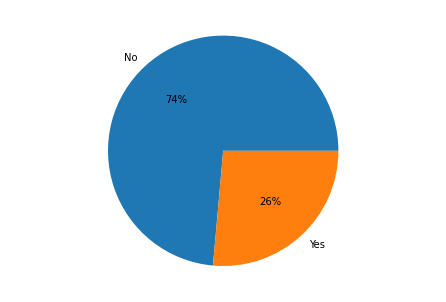

In [7]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.axis('equal')
labels = ['No', 'Yes']
churn = df.Churn.value_counts()
ax.pie(churn, labels=labels, autopct='%.0f%%')
plt.savefig('churn percentage.png')
plt.show()

Numerical

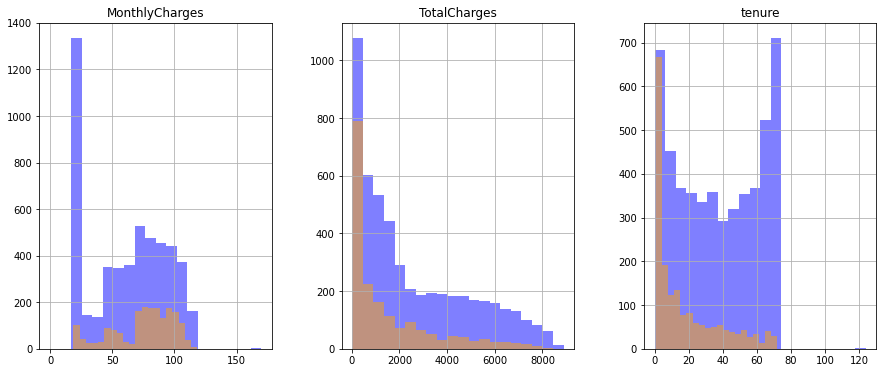

In [8]:
numerical_features = ['MonthlyCharges', 'TotalCharges', 'tenure']
fig, ax = plt.subplots(1, 3, figsize=(15, 6))
df[df.Churn == 'No'][numerical_features].hist(bins=20, color='blue', alpha=0.5, ax=ax)
df[df.Churn == 'Yes'][numerical_features].hist(bins=20, color='orange', alpha=0.5, ax=ax)
plt.savefig('numerical.png')
plt.show()

Categorical

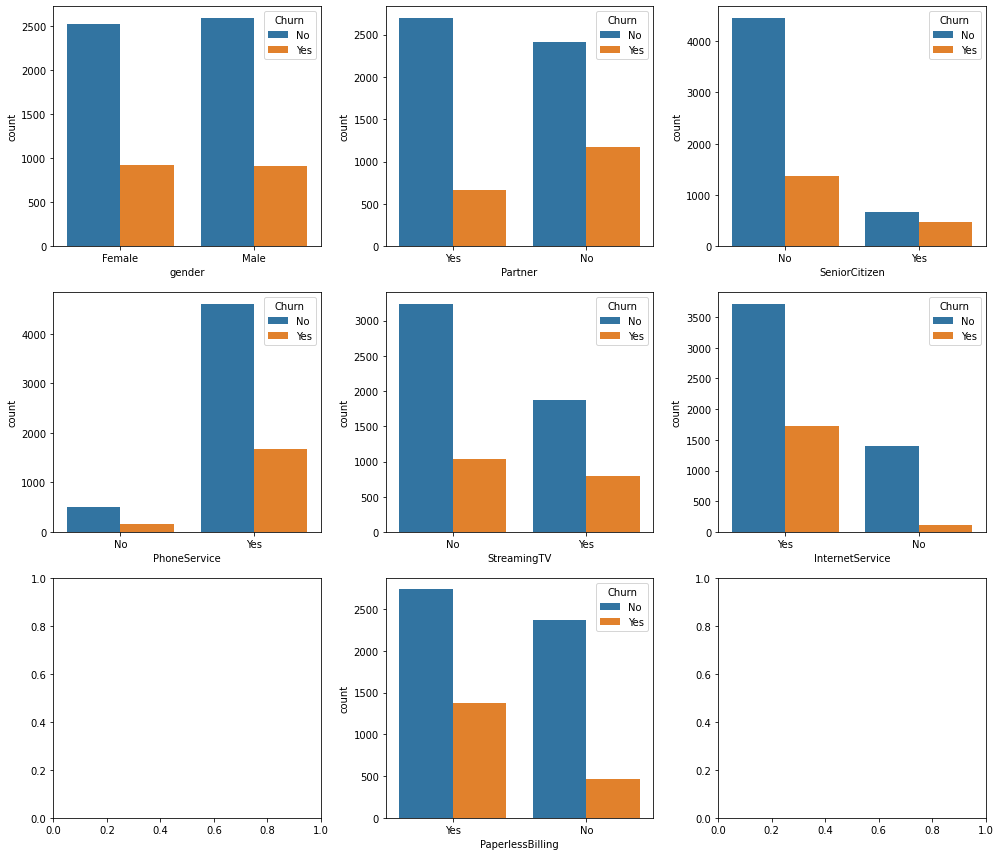

In [9]:
fix, ax = plt.subplots(3,3, figsize=(14, 12))
sns.countplot(data=df, x='gender', hue='Churn', ax=ax[0][0])
sns.countplot(data=df, x='Partner', hue='Churn', ax=ax[0][1])
sns.countplot(data=df, x='SeniorCitizen', hue='Churn', ax=ax[0][2])
sns.countplot(data=df, x='PhoneService', hue='Churn', ax=ax[1][0])
sns.countplot(data=df, x='StreamingTV', hue='Churn', ax=ax[1][1])
sns.countplot(data=df, x='InternetService', hue='Churn', ax=ax[1][2])
sns.countplot(data=df, x='PaperlessBilling', hue='Churn', ax=ax[2][1])
plt.tight_layout()
plt.savefig('categorial.png')
plt.show()

## Data Preprocessing

In [10]:
cleaned_df = df.drop(['customerID', 'UpdatedAt'], axis=1)
print(cleaned_df.head())

   gender SeniorCitizen Partner  tenure PhoneService StreamingTV  \
0  Female            No     Yes       1           No          No   
1    Male            No     Yes      60          Yes          No   
2    Male            No      No       5          Yes         Yes   
3  Female            No     Yes      72          Yes         Yes   
4  Female            No     Yes      56          Yes         Yes   

  InternetService PaperlessBilling  MonthlyCharges  TotalCharges Churn  
0             Yes              Yes           29.85         29.85    No  
1              No              Yes           20.50       1198.80    No  
2             Yes               No          104.10        541.90   Yes  
3             Yes              Yes          115.50       8312.75    No  
4             Yes               No           81.25       4620.40    No  


Encoding

In [11]:
for column in cleaned_df.columns:
  if cleaned_df[column].dtype == np.float64 or cleaned_df[column].dtype == np.int64: continue
  cleaned_df[column] = LabelEncoder().fit_transform(cleaned_df[column])
print(cleaned_df.describe())

            gender  SeniorCitizen      Partner       tenure  PhoneService  \
count  6950.000000    6950.000000  6950.000000  6950.000000   6950.000000   
mean      0.504317       0.162302     0.483309    32.423165      0.903741   
std       0.500017       0.368754     0.499757    24.581073      0.294967   
min       0.000000       0.000000     0.000000     0.000000      0.000000   
25%       0.000000       0.000000     0.000000     9.000000      1.000000   
50%       1.000000       0.000000     0.000000    29.000000      1.000000   
75%       1.000000       0.000000     1.000000    55.000000      1.000000   
max       1.000000       1.000000     1.000000   124.000000      1.000000   

       StreamingTV  InternetService  PaperlessBilling  MonthlyCharges  \
count  6950.000000      6950.000000       6950.000000     6950.000000   
mean      0.384317         0.783453          0.591942       64.992201   
std       0.486468         0.411921          0.491509       30.032040   
min       0.00

Splitting the dataset

In [12]:
X = cleaned_df.drop('Churn', axis=1)
y = cleaned_df['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print('X_train shape: ', X_train.shape, ', y_train shape: ', y_train.shape)
print('Churn percentage in training data: ')
print(y_train.value_counts(normalize=True))
print('X_test shape: ', X_test.shape, ' ,y_test shape: ', y_test.shape)
print('Churn percentage in testing data: ')
print(y_test.value_counts(normalize=True))

X_train shape:  (4865, 10) , y_train shape:  (4865,)
Churn percentage in training data: 
0    0.734841
1    0.265159
Name: Churn, dtype: float64
X_test shape:  (2085, 10)  ,y_test shape:  (2085,)
Churn percentage in testing data: 
0    0.738129
1    0.261871
Name: Churn, dtype: float64


## Model Selection

Logistic Regression

In [13]:
log_model = LogisticRegression().fit(X_train, y_train)
print(log_model)

LogisticRegression()


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Performance of training data (metrics)

In [14]:
y_train_pred = log_model.predict(X_train)
print('Classification Report Training Model (Logistic Regression): ')
print(classification_report(y_train, y_train_pred))

Classification Report Training Model (Logistic Regression): 
              precision    recall  f1-score   support

           0       0.83      0.90      0.87      3575
           1       0.65      0.49      0.56      1290

    accuracy                           0.80      4865
   macro avg       0.74      0.70      0.71      4865
weighted avg       0.78      0.80      0.79      4865



Performance of training data (plots)

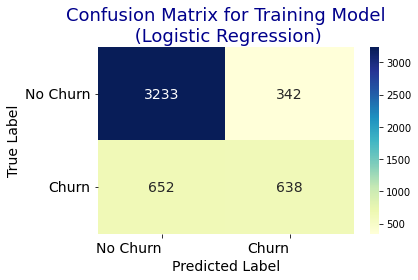

In [15]:
confusion_matrix_df = pd.DataFrame((confusion_matrix(y_train, y_train_pred)), ('No Churn', 'Churn'), ('No Churn', 'Churn'))

plt.figure()
heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={'size':14}, fmt='d', cmap='YlGnBu')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)

plt.title('Confusion Matrix for Training Model\n (Logistic Regression)', fontsize=18, color='darkblue')
plt.ylabel('True Label', fontsize=14)
plt.xlabel('Predicted Label', fontsize=14)
plt.tight_layout()
plt.savefig('performance of training data.png')
plt.show()

Performance of test data (metrics)

In [16]:
y_test_pred = log_model.predict(X_test)
print('Classification Report Training Model (Logistic Regression): ')
print(classification_report(y_test, y_test_pred))

Classification Report Training Model (Logistic Regression): 
              precision    recall  f1-score   support

           0       0.83      0.90      0.87      1539
           1       0.64      0.48      0.55       546

    accuracy                           0.79      2085
   macro avg       0.73      0.69      0.71      2085
weighted avg       0.78      0.79      0.78      2085



Performance of test data (plots)

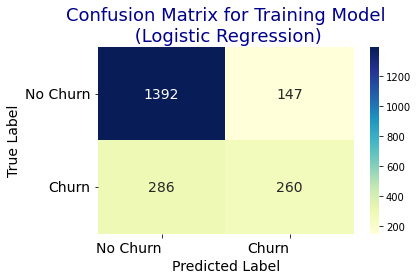

In [17]:
confusion_matrix_df = pd.DataFrame((confusion_matrix(y_test, y_test_pred)), ('No Churn', 'Churn'), ('No Churn', 'Churn'))

plt.figure()
heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={'size':14}, fmt='d', cmap='YlGnBu')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)

plt.title('Confusion Matrix for Training Model\n (Logistic Regression)', fontsize=18, color='darkblue')
plt.ylabel('True Label', fontsize=14)
plt.xlabel('Predicted Label', fontsize=14)
plt.tight_layout()
plt.savefig('performance of test data.png')
plt.show()

Save the best model

In [18]:
pickle.dump(log_model, open('customer_churn.pkl', 'wb'))